In [5]:
#!pip install librosa
#!pip install tensorflow
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import IPython.display as ipd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%load_ext tensorboard

librosa.load() method loads an audio file as a floating point time series. Audio will be automatically resampled to the given rate (default sr=22050). It can be stated as librosa.load(sample, sr=11025)

In [262]:
# try one .wav sample
sample = r"/Users/shuofeng/Desktop/5741project/Data/genres_original/blues/blues.00000.wav"  # single music
x,freq = librosa.load(sample)
sr=freq
print(x.shape)
print(type(x))
print(freq)
print(type(freq))

(661794,)
<class 'numpy.ndarray'>
22050
<class 'int'>


<Figure size 720x216 with 0 Axes>

Text(0.5, 1.0, 'Single Bark Wave Plot')

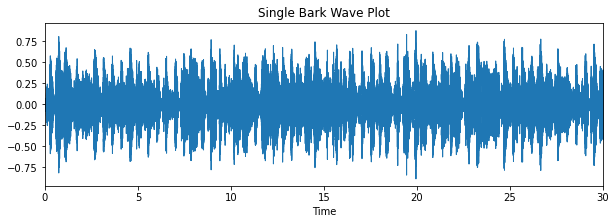

In [10]:
# play sound with ipd
import IPython.display as ipd
ipd.Audio(sample)

import librosa.display
plt.figure(figsize=(10,3))
plt.title("blues.00000")
librosa.display.waveplot(x,sr=freq)


### Sound Processing Basics & Features

In [105]:
win_length=n_fft, window='hann'

(1025, 1293)

<Figure size 720x288 with 0 Axes>

Text(0.5, 1.0, 'Spectogram of blues.00000')

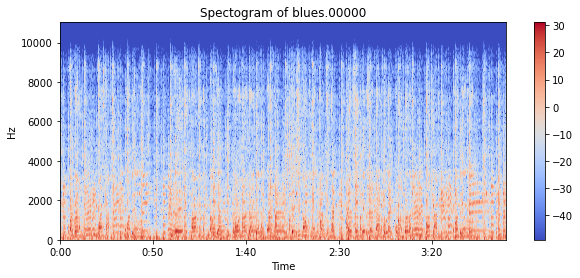

In [126]:
# Spectogram
X=librosa.stft(x,win_length=256, window='hann') #stft -> Short-time Fourier transform
X_db=librosa.amplitude_to_db(abs(X)) #Translation from amplitude to desibel(db) value
plt.figure(figsize=(10,4))
librosa.display.specshow(X_db, sr=sr,x_axis="time",y_axis="hz")
plt.title("Spectogram of blues.00000")
plt.colorbar()

shape of mfcc: (20, 1293)


<Figure size 720x288 with 0 Axes>

Text(0.5, 1.0, 'Mel-Frequency Cepstral Coefficients')

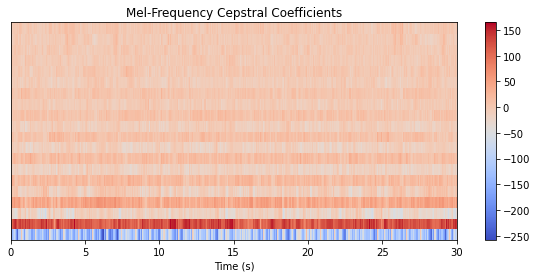

In [13]:
# Mel-Frequency Cepstral Coefficients (MFCC) dimension = (20, 1293)
mfcc=librosa.feature.mfcc(x,sr=sr)
print("shape of mfcc:" ,mfcc.shape)


plt.figure(figsize=(10,4))
librosa.display.specshow(mfcc,x_axis="s")
plt.title("Mel-Frequency Cepstral Coefficients")
plt.colorbar()

The Mel Scale, mathematically speaking, is the result of some non-linear transformation of the frequency scale. This Mel Scale is constructed such that sounds of equal distance from each other on the Mel Scale, also “sound” to humans as they are equal in distance from one another.
In contrast to Hz scale, where the difference between 500 and 1000 Hz is obvious, whereas the difference between 7500 and 8000 Hz is barely noticeable.

(256, 1293)


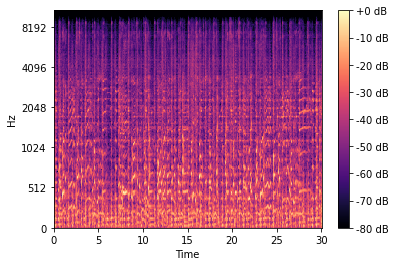

In [121]:
#  MEL spectrogram  还没转成256
S = librosa.feature.melspectrogram(x, sr=sr, n_fft=n_fft, hop_length=512, n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
print(S_DB.shape)

(256, 255)


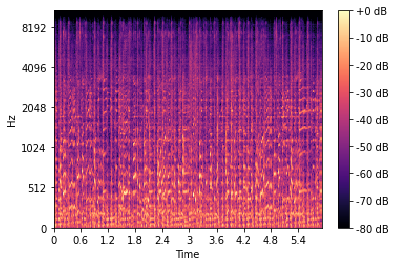

In [130]:
# MEL spectrgram 256*256    不会转 hop_length = 2598
n_mels = 256
n_fft = 2048
hop_length = 512
#mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)

S = librosa.feature.melspectrogram(x, sr=sr, n_fft=n_fft, hop_length=2598, n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
print(S_DB.shape)

## feature extraction on one sample


In [208]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout

img_in = Input(shape = (256,255,1), name = 'FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs = [img_in], outputs = [n_layer], name = 'FeatureGenerationModel')
feature_model.summary()
result = model.predict(S_DB.reshape(1,256,255,1))

print(result.shape)

Model: "FeatureGenerationModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeatureNet_ImageInput (Input [(None, 256, 255, 1)]     0         
_________________________________________________________________
conv2d_187 (Conv2D)          (None, 254, 253, 8)       80        
_________________________________________________________________
batch_normalization_27 (Batc (None, 254, 253, 8)       32        
_________________________________________________________________
activation_27 (Activation)   (None, 254, 253, 8)       0         
_________________________________________________________________
conv2d_188 (Conv2D)          (None, 252, 251, 16)      1168      
_________________________________________________________________
batch_normalization_28 (Batc (None, 252, 251, 16)      64        
_________________________________________________________________
activation_28 (Activation)   (None, 252, 251

### 为什么两种cnn结果不一样

In [220]:
import imageio
from keras.layers import *
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np
#from scipy.misc import imsave
import  numpy  as  np
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dropout, Flatten, Dense
#from keras.applications import ResNet50
from tensorflow.keras.applications import ResNet50
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import matplotlib.pyplot as plt
#from keras.applications.ResNet50 import preprocess_input

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(256, 255, 1), padding='VALID'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='VALID'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu', padding='VALID'))
model.add(Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu', padding='VALID'))
model.add(AveragePooling2D(pool_size=(19, 19)))

# set of FC => RELU layers
#model.add(Flatten())

#getting the summary of the model (architecture)
model.summary()

img_data = S_DB
img_data = np.expand_dims(img_data, axis=0)
#img_data = img_data.reshape(1,256,255,1)
#img_data = tf.expand_dims(img_data, axis=-1)
img_data = preprocess_input(img_data)

#img_data = tf.expand_dims(img_data, axis=-1)
img_data = img_data.reshape(-1,256,255,1)
vgg_feature = model.predict(img_data)
#print the shape of the output (so from your architecture is clear will be (1, 128))
#print shape
#print the numpy array output flatten layer
print(vgg_feature.shape)


Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_215 (Conv2D)          (None, 254, 253, 64)      640       
_________________________________________________________________
conv2d_216 (Conv2D)          (None, 252, 251, 64)      36928     
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 126, 125, 64)      0         
_________________________________________________________________
conv2d_217 (Conv2D)          (None, 124, 123, 128)     73856     
_________________________________________________________________
conv2d_218 (Conv2D)          (None, 122, 121, 128)     147584    
_________________________________________________________________
average_pooling2d_47 (Averag (None, 6, 6, 128)         0         
Total params: 259,008
Trainable params: 259,008
Non-trainable params: 0
_______________________________________________

In [233]:
# get feature vector of size 128 of one audio sample
res = np.mean(vgg_feature, axis=1)
res = np.mean(res, axis=1)
res = res.reshape(128)
res.shape

(128,)

## feature extraction for all music sample

In [246]:
d = pd.read_excel(music_file_path + genres[0] + 'filename.xlsx')
d

,genres,number,type,filename
0,blues.,0,.wav,blues.00000.wav
1,blues.,1,.wav,blues.00001.wav
2,blues.,2,.wav,blues.00002.wav
3,blues.,3,.wav,blues.00003.wav
4,blues.,4,.wav,blues.00004.wav
...,...,...,...,...
95,blues.,95,.wav,blues.00095.wav
96,blues.,96,.wav,blues.00096.wav
97,blues.,97,.wav,blues.00097.wav
98,blues.,98,.wav,blues.00098.wav


In [272]:
### data prepraration, iterate over music file names
features_all = []
music_file_path = "/Users/shuofeng/Desktop/5741project/Data/genres_original/"  # path of csv name files
data_path = "/Users/shuofeng/Desktop/5741project/Data/genres_original/" # path to folder containing music files

genres = ['blues', 'classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

# extract features vector of size = 128 for each music file 
for i in range(len(genres)):
    features = []
    music_file_path = "/Users/shuofeng/Desktop/5741project/Data/genres_original/"
    data_path = "/Users/shuofeng/Desktop/5741project/Data/genres_original/"
    # get collected music file name of each genre of music
    df = pd.read_excel(music_file_path + genres[i] + 'filename.xlsx')
    
    # iterate on each music of each genre to extract features
    for name in tqdm(df.iterrows(),  desc='Progress'):
        sig , sr = librosa.load(data_path+ genres[i] + '/' + name[1][3]) # read each music file
    
        # get mel spectrogram for each
        S = librosa.feature.melspectrogram(sig, sr=sr, n_fft=n_fft, hop_length=2598, n_mels=n_mels)
        S_DB = librosa.power_to_db(S, ref=np.max)
        n = S_DB.shape[0]
        m = S_DB.shape[1]

      
        # get vector features for each music file
    
        model = Sequential()
        model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(n, m, 1), padding='VALID'))
        model.add(Conv2D(64, kernel_size=(3, 3), padding='VALID'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Block 2
        model.add(Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu', padding='VALID'))
        model.add(Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu', padding='VALID'))
        model.add(AveragePooling2D(pool_size=(19, 19)))

        # set of FC => RELU layers
        #model.add(Flatten())

        #getting the summary of the model (architecture)
        #model.summary()

        img_data = S_DB
        img_data = np.expand_dims(img_data, axis=0)
        #img_data = img_data.reshape(1,256,255,1)
        #img_data = tf.expand_dims(img_data, axis=-1)
        img_data = preprocess_input(img_data)

        #img_data = tf.expand_dims(img_data, axis=-1)
        img_data = img_data.reshape(-1,n,m,1)
        vgg_feature = model.predict(img_data)
        
        # get feature vector of size 128 of one audio sample
        res = np.mean(vgg_feature, axis=1)
        res = np.mean(res, axis=1)
        res = res.reshape(128)
        

        features.append(res)
    features_all.append(features)

    


Progress: 100it [00:12,  8.14it/s]
Progress: 100it [00:11,  8.36it/s]
Progress: 100it [00:12,  7.87it/s]
Progress: 100it [00:12,  7.70it/s]
Progress: 100it [00:13,  7.46it/s]
Progress: 100it [00:13,  7.63it/s]
Progress: 100it [00:14,  7.09it/s]
Progress: 100it [00:13,  7.48it/s]
Progress: 100it [00:12,  7.84it/s]
Progress: 100it [00:12,  8.13it/s]


In [319]:
dataframe = pd.DataFrame()
df_new = pd.concat([dataframe, pd.DataFrame(features_all[0])], axis=0)
df_new = pd.concat([df_new, pd.DataFrame(features_all[1])], axis=0)
df_new = pd.concat([df_new, pd.DataFrame(features_all[2])], axis=0)
df_new = pd.concat([df_new, pd.DataFrame(features_all[3])], axis=0)
df_new = pd.concat([df_new, pd.DataFrame(features_all[4])], axis=0)
df_new = pd.concat([df_new, pd.DataFrame(features_all[5])], axis=0)
df_new = pd.concat([df_new, pd.DataFrame(features_all[6])], axis=0)
df_new = pd.concat([df_new, pd.DataFrame(features_all[7])], axis=0)
df_new = pd.concat([df_new, pd.DataFrame(features_all[8])], axis=0)
df_new = pd.concat([df_new, pd.DataFrame(features_all[9])], axis=0)


In [321]:
df_new.to_csv('CNN_featrues.csv')

### prepare graph data

In [293]:
import networkx as nx
a = 1
G = nx.Graph()
for i in range(len(features_blues)):
    G.add_nodes_from(([features_blues[i]]))


#edges = [(2,1),(2,2),(3,2),(4,3),(6,4),(7,5),(14,5)]
#G.add_edges_from(edges)

nx.draw(G, with_labels=True, font_weight='bold')
import matplotlib.pyplot as plt
plt.show()

ValueError: too many values to unpack (expected 2)

In [291]:
G.add_nodes_from(([2,3]))